- LANGUAGE: Python 3
- VERSION: v1.2
           (v1.2 - 2018-07-21 - Jupyter Notebook)
           (v1.1 - 2018-07-06 - Python)
           (v1.0 - 2015-11-25 - Python)
- AUTHORS: 
          Tristan Benoist - tristan.benoist@irsamc.ups-tlse.fr
          Reda Chhaibi - reda.chhaibi@math.univ-toulouse.fr
- DESCRIPTION:  The aim is to study the limit of a strong noise $\gamma \rightarrow \infty$ of a two-dimensional SDE.

The SDE is given by:
$$ dX_t= b(X_t)dt + \gamma \sigma(X_t)dW_t \ ,$$
where the vector fields $b$ and $\sigma$ are 
$$ b(x) = L x \ ,$$
$$ \sigma(x) = R x - x \langle R, x \rangle = \left( R - \langle R, x \rangle \right) x \ .$$
Here $L$ is the dual of a Markov generator and $R$ is an $n \times n$ matrix.

Plotting uses pylab (non-interactive) and ipyvolume (interactive):
- Github repository:
https://github.com/maartenbreddels/ipyvolume
- Documentation:
https://ipyvolume.readthedocs.io/
- Install instructions:
https://ipyvolume.readthedocs.io/en/latest/install.html

# I. Euler schemes

The same comment for numerical schemes is valid in this case as in 2d

In [1]:
import numpy as np            # Matrix computation library (as a more general mathematical purpose)
import numpy.random as random # Pseudo random numbers generation sub library

#--- Parameters and functions defining the SDE---#
dim = 3
T=np.asmatrix([[-2.,1.,1.],[1.,-2.,1.],[1.,1.,-2.]])
r=np.asmatrix([[-1.,0,0],[0,1.,0],[0,0,0]])
gamma  = 100.
id_matrix = np.eye(dim,dim)

def eds_b(q):
    """ Returns drift. """
    return T*q

def eds_b_prime(q):
    """ Returns drift's derivative. Useful for Milstein scheme."""
    return 0

def eds_sigma(q):
    """ Returns volatility. """
    return r*q-q*sum(r*q)
    #return abs(x*(1.-x))**.25
    #return np.sin(np.pi*x)
	#return x*(x-1)*(x+1)

def eds_sigma_prime(q, i):
    """ Returns volatility's derivative. """
    s   = sum(r*q)
    r_i = r[:,i]
    e_i = id_matrix[:,i]
    return r_i-e_i*sum(r*q)-q*sum(r_i)
    #return abs(x*(1.-x))**.25
    #return np.sin(np.pi*x)
	#return x*(x-1)*(x+1)
    

def constrains(x):
    """ Returns True if x belongs to the theoretical domain of the process. """
    result=True
    for coord in np.asarray(x):
    	if coord<=0 or coord>=1:
    		result=False	
    return result # We do not test whether \sum x_i = 1. Insufficient numerical precision.


def compute_step_Euler(x,h,dW):
    b_x     = eds_b(x)
    sigma_x = eds_sigma(x) 
    return x + b_x*h + gamma*sigma_x*dW

def compute_step_Milstein(x,h,dW):
    b_x     = eds_b(x)
    sigma_x = eds_sigma(x)
    x_euler = x + b_x*h + gamma*sigma_x*dW
    b_prime_x = eds_b_prime(x)
    return x_euler + 1./2.*b_x*b_prime_x*(dW**2-h)

def compute_step_RungeKutta(x,h,dW):
    b_x     = eds_b(x)
    sigma_x = eds_sigma(x) 
    x_euler = x + b_x*h + gamma*sigma_x*dW
    sigma_prime_x = eds_sigma(x2)
    y = 0
    for i in range(dim):
        y = y + sigma_x[i]*eds_sigma_prime(x,i)
    return x_euler + 0.5*gamma*gamma*(dW**2-h)*y

def compute_step(x,h,dW):
    return compute_step_Euler(x,h,dW)
    
#--- Numerical integrations and stochastics---#
def sampleBM(t,stepCount):
    """ Samples a Brownian motion up to time t, with stepCount steps"""
    h=t/float(stepCount)
    W=[0]
    W=W+random.normal(0.,np.sqrt(h),stepCount)
    return np.cumsum(W)

def sampleBB_midpoint(h):
    """ Samples midpoint in a Brownian bridge, with length h"""
    return 0.5*random.normal()*np.sqrt(h)

def compute_step_with_constrains(x,h,dW):
    new_x = compute_step(x,h,dW)
    if constrains(new_x):
        return new_x
    else:
        #Faster
        #return x
        #print("Subdivision %f -> %f"%(x, new_x))
        dP = sampleBB_midpoint(h)
        intermediate_x = compute_step_with_constrains(x,0.5*h,0.5*dW+dP)
        #print("Intermediate %f -> %f -> %f"%(x, intermediate_x, new_x))
        return compute_step_with_constrains(intermediate_x,0.5*h,0.5*dW-dP)

def SDE_integration_process(x,t,W,callback):
    """ x condition initiale, h pas de temps, W realization d'un Wiener avec des points equidistant pour le temps t. La fonction renvoie les point X_kh.
        Le processus respecte les contraintes données par la fonction du même nom.
        """
    h = t/(len(W)-1)
    percent = 0
    X = [x]
    for k in range(len(W)-1):
        x   = compute_step_with_constrains(x,h,W[k+1]-W[k])
        X.append(x)
        # Callback only when one percent is done
        # This minimizes costly communications between python kernel and notebook
        if callback is not None and percent<np.floor(100*k/len(W)):
            percent = np.ceil(100*k/len(W))
            callback(percent)
    return X

In [2]:
from ipywidgets import FloatProgress
from IPython.display import display

random.seed(1)#change to find good realization. Comment to select "random" realizations.

#Paramètres de la simulation
X_0=np.asmatrix([[1/5.],[1/5.],[3/5.]]) # Initial condition
FinalTime=1.    # temps (physique) final de l'évolution
Npas=int(1e6)   # Nombres de pas de calcul (i.e. pas de temps discret=FinalTime/Npas)
#--- Fin des paramètres ---#

t = [n*FinalTime/float(Npas) for n in range(Npas)]

print("- Sampling Brownian motion...")
W=sampleBM(FinalTime,Npas)

print("- Solving SDE...")
X=[X_0]# Initialization of the path
x=X_0
# Progress Bar
f = FloatProgress(min=0, max=100)
display(f)
def callback(percent):
    f.value = percent
# Computation
X = SDE_integration_process( X_0, FinalTime, W, callback)
# Done
callback(100)
print("- Done!")


- Sampling Brownian motion...
- Solving SDE...


FloatProgress(value=0.0)

- Done!


In [2]:
### Projection from R^3 to simplex. ###
def transform_to_simplex(x_array):
    """ Mapping a sequence of points in R^3 to the simplex in R^2 """
    T=np.asmatrix([[0.5,0.5,-1.],[0.866,-0.866,0.]])
    simplex_points=[]
    for x in x_array:
        simplex_points.append(T*x)
    return [[x.item(0) for x in simplex_points],[x.item(1) for x in simplex_points]]

#Info
print("Minima of coordinates:")
print( np.min(X))

# Transform
plot_X=transform_to_simplex(X)
x = np.array( plot_X[0] )
y = np.array( plot_X[1] )
z = np.array( range( len(plot_X[0]) ) )

import pylab
from mpl_toolkits.mplot3d import Axes3D # Pour dessiner en 3D.
fig=pylab.figure()
ax = fig.gca(projection='3d')
print("Plotting using pylab...")
ax.plot(x, y, z,linewidth=1,alpha=.4)
pylab.xlim(-1, 1)
pylab.ylim(-1, 1)
pylab.show()
pylab.close('all')

import ipyvolume
print("Plotting using ipyvolume...")
ipyvolume.figure( width=1024, height=800)
ipyvolume.pylab.xlim(-1, 1)
ipyvolume.pylab.ylim(-1, 1)
ipyvolume.pylab.zlabel("Time")
plot = ipyvolume.pylab.plot(x, y, z, color='red', linewidth=1)

from ipywidgets import FloatSlider, ColorPicker, VBox, jslink
size = FloatSlider(min=0, max=30, step=0.1)
size_selected = FloatSlider(min=0, max=30, step=0.1)
color = ColorPicker()
color_selected = ColorPicker()
jslink((plot, 'size'), (size, 'value'))
jslink((plot, 'size_selected'), (size_selected, 'value'))
jslink((plot, 'color'), (color, 'value'))
jslink((plot, 'color_selected'), (color_selected, 'value'))
VBox([ipyvolume.gcc(), size, size_selected, color, color_selected])
#EOF

Minima of coordinates:


NameError: name 'X' is not defined

# II. Doss-Sussman

In [3]:
import numpy as np            # Matrix computation library (as a more general mathematical purpose)
import numpy.random as random # Pseudo random numbers generation sub library

#--- Parameters and functions defining the SDE---#
dim = 3
L=np.asmatrix([[-2.,1.,1.],[1.,-2.,1.],[1.,1.,-2.]])
R=np.asmatrix([[1.,0,0],[0,2.,0],[0,0,3.]])
R_diag = R.diagonal().T
gamma  = 100.
id_matrix = np.eye(dim,dim)

def normalize(x):
    """ Normalizes x to a probability. """
    return x/sum(x)

def compute_step_DossSussman(x,h,dW):
    m = sum(R*x)
    y = x
    Lx = L*x
    for i in range(dim):
        inc_finite  = h*Lx[i]/x[i]
        inc_doleans = dW*( R[i,i] - m )
        y[i] = y[i]*(1+inc_finite)*(1+inc_doleans)
    return normalize(y)

def compute_step_DossSussman2(x,h,dW):
    m = sum(R*x)
    y = x + h*L*x
    inc_doleans = gamma*dW*( R_diag - m ) - 0.5*gamma*gamma*h*np.multiply( ( R_diag - m ), ( R_diag - m ) )
    inc_doleans = np.exp( inc_doleans )
    y = np.multiply(y, inc_doleans)
    return normalize(y)

#--- Numerical integrations and stochastics---#
def sampleW_dW(t,stepCount):
    """ Samples a Brownian motion up to time t, with stepCount steps"""
    h=t/float(stepCount)
    dW=random.normal(0.,np.sqrt(h),stepCount)
    W=[0]
    W=W+dW
    return np.cumsum(W), dW

def DossSussman_process(x,t,dW,callback):
    """ x condition initiale, h pas de temps, W realization d'un Wiener avec des points equidistant pour le temps t. La fonction renvoie les point X_kh.
        Le processus respecte les contraintes données par la fonction du même nom.
        """
    h = t/(len(dW))
    percent = 0
    X    = R_diag*W
    mean = np.copy(W)
    var  = np.copy(W)
    X[:, 0] = x
    for k in range(len(dW)-1):
        x = X[:, k]
        y = x + h*L*x
        dw = dW[k]
        #
        mean[k] = sum(R*x)
        var[k]  = sum(R*R*x)-mean[k]*mean[k]
        #
        inc = R_diag - mean[k]
        inc_doleans = gamma*dw*inc - 0.5*gamma*gamma*h*np.multiply( inc, inc )
        inc_doleans = np.exp( inc_doleans )
        y = np.multiply(y, inc_doleans)
        #
        X[:, k+1] = normalize(y)
        # Callback only when one percent is done
        # This minimizes costly communications between python kernel and notebook
        if callback is not None and percent<np.floor(100*k/len(W)):
            percent = np.ceil(100*k/len(W))
            callback(percent)
    # Last step
    x = X[:, -1]
    mean[-1] = sum(R*x)
    var[-1]  = sum(R*R*x)-mean[k]*mean[k]
    #
    return X, mean, var

In [5]:
from ipywidgets import FloatProgress
from IPython.display import display

random.seed(4) #change to find good realization. Comment to select "random" realizations.

#Paramètres de la simulation
X_0=np.asmatrix([[1/3.],[1/3.],[1/3.]]) # Initial condition
FinalTime=3.    # temps (physique) final de l'évolution
Npas=int(1e6)   # Nombres de pas de calcul (i.e. pas de temps discret=FinalTime/Npas)
#--- Fin des paramètres ---#

t = np.array([n*FinalTime/float(Npas) for n in range(Npas)])

print("- Sampling Brownian motion...")
W, dW = sampleW_dW(FinalTime,Npas)

print("- Solving SDE...")
X=[X_0]# Initialization of the path
x=X_0
# Progress Bar
f = FloatProgress(min=0, max=100)
display(f)
def callback(percent):
    f.value = percent
# Computation
X, mean, var = DossSussman_process( X_0, FinalTime, dW, callback)
# Done
callback(100)
print("- Done!")


- Sampling Brownian motion...
- Solving SDE...


FloatProgress(value=0.0)

- Done!


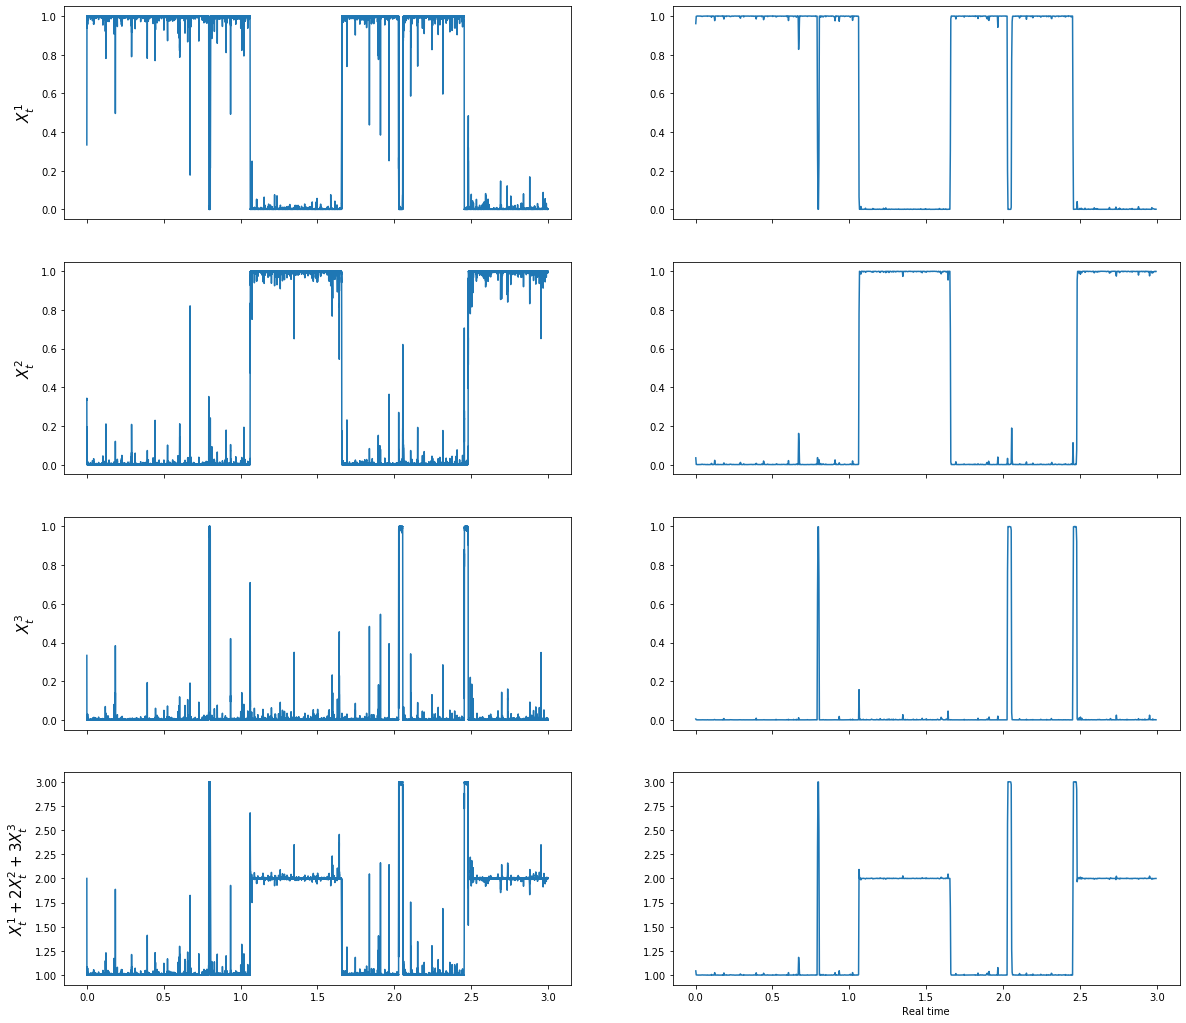

In [77]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,18)

def smoothing(x, sampling):
    y = np.zeros(sampling, dtype=float)
    begin = 0
    mid   = np.floor(len(y)/2).astype(int)
    end   = sampling
    ratio = np.floor(len(x)/sampling).astype(int)
    for i in range(0, mid) :
        y[i] = np.mean( x[i*ratio: (i+1)*ratio] )
    for i in range(mid,end) :
        y[i] = np.mean( x[(i-1)*ratio:i*ratio] )
    return y

fig = plt.figure()
ax  = fig.subplots(4,2, sharex=True)
for i in range(3):
    x = X[i,:].reshape([Npas,1])
    ax[i,0].plot(t, x )
    ax[i,1].plot( smoothing(t, 1000), smoothing(x, 1000) )
    ax[i,0].set_ylabel( ylabel="$X^{%d}_t$"%(i+1), fontsize=15 )
ax[3,0].plot(t, mean)
ax[3,1].plot( smoothing(t, 1000), smoothing(mean, 1000) )
ax[3,0].set_ylabel( ylabel="$X^1_t + 2 X^2_t + 3 X_t^3$", fontsize=15 )
plt.xlabel("Real time")

plt.savefig("threeState_combination.png")
plt.savefig("threeState_combination.svg")
plt.show()
plt.close('all')

In [70]:
print(mean[-1])
print(sum(R*X[:,-1]))

3.392056156371946
[[1.99816237]]


Plotting mean and variance...
- Using pylab...


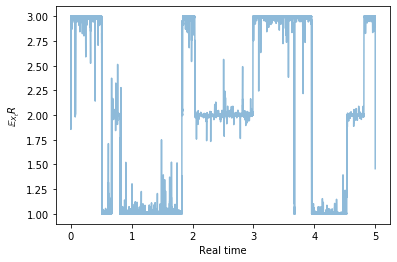

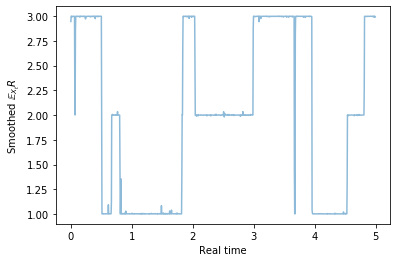

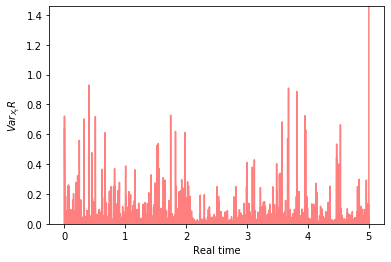

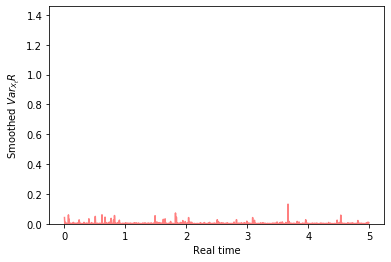

In [7]:
import numpy as np 
import pylab # Plotting library
from ipywidgets import FloatProgress
from IPython.display import display

print("Plotting mean and variance...")

t = [n*FinalTime/float(Npas) for n in range(Npas)]

def smoothing(x, sampling):
    y = np.zeros(sampling, dtype=float)
    begin = 0
    mid   = np.floor(len(y)/2).astype(int)
    end   = sampling
    ratio = np.floor(len(x)/sampling).astype(int)
    for i in range(0, mid) :
        y[i] = np.mean( x[i*ratio: (i+1)*ratio] )
    for i in range(mid,end) :
        y[i] = np.mean( x[(i-1)*ratio:i*ratio] )
    return y

print("- Using pylab...")
pylab.plot(t,mean,alpha=.5)
pylab.ylabel("$\mathbb{E}_{X_t} R$")
pylab.xlabel("Real time")
pylab.savefig("threeState_mean.png")
pylab.savefig("threeState_mean.svg")
pylab.show()
pylab.close('all')

pylab.plot( smoothing(t, 1000), smoothing(mean, 1000), alpha=.5)
pylab.ylabel("Smoothed $\mathbb{E}_{X_t} R$")
pylab.xlabel("Real time")
pylab.savefig("threeState_mean_smoothed.png")
pylab.savefig("threeState_mean_smoothed.svg")
pylab.show()
pylab.close('all')

y_max = np.max(var)
pylab.plot(t,var,alpha=.5, color="red")
pylab.ylim(0, y_max)
pylab.ylabel("${Var}_{X_t} R$")
pylab.xlabel("Real time")
pylab.savefig("threeState_var.png")
pylab.savefig("threeState_var.svg")
pylab.show()
pylab.close('all')

pylab.plot( smoothing(t, 1000), smoothing(var, 1000), alpha=.5, color="red")
pylab.ylim(0, y_max)
pylab.ylabel("Smoothed ${Var}_{X_t} R$")
pylab.xlabel("Real time")
pylab.savefig("threeState_var_smoothed.png")
pylab.savefig("threeState_var_smoothed.svg")
pylab.show()
pylab.close('all')

#print("- Using bqplot...")
#import bqplot.pyplot as plt
#plt.figure(title='Mean')
#plt.plot(t, mean)
#plt.show()

#plt.figure(title='Variance')
#plt.plot(t, var)
#plt.show()

#EOF

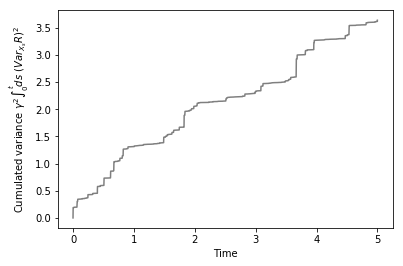

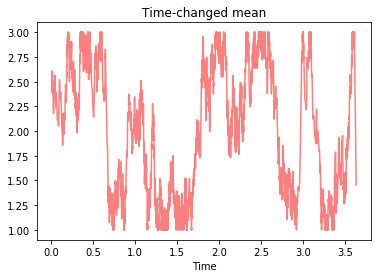

In [5]:
cumulated = gamma*gamma*np.cumsum( np.multiply(var, var)/Npas )
pylab.plot(t, cumulated, alpha=.5, color="black")
pylab.ylabel("Cumulated variance $\gamma^2 \int_0^t ds \ ({Var}_{X_s} R)^2$")
pylab.xlabel("Time")
pylab.savefig("threeState_cumulated.png")
pylab.savefig("threeState_cumulated.svg")
pylab.show()
pylab.close('all')

pylab.plot( cumulated, mean,alpha=.5, color="red")
pylab.title( "Time-changed mean" )
pylab.xlabel("Time")
pylab.savefig("threeState_mean_timechange.png")
pylab.savefig("threeState_mean_timechange.svg")
pylab.show()
pylab.close('all')

Plotting using pylab...


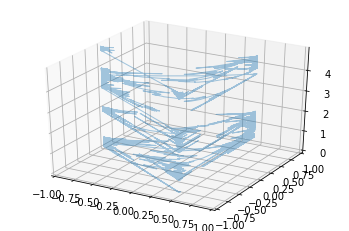

Plotting using ipyvolume...


In [6]:
### Projection from R^3 to simplex. ###
def transform_to_simplex(x_array):
    """ Mapping a sequence of points in R^3 to the simplex in R^2 """
    T=np.asmatrix([[0.5,0.5,-1.],[0.866,-0.866,0.]])
    simplex_points=[]
    for i in range(len(W)):
        x = x_array[:,i]
        simplex_points.append(T*x)
    return [[x.item(0) for x in simplex_points],[x.item(1) for x in simplex_points]]

# Transform
plot_X=transform_to_simplex(X)
x = np.array( plot_X[0] )
y = np.array( plot_X[1] )
z = np.array( t )

#Pylab plot
import pylab
from mpl_toolkits.mplot3d import Axes3D # Pour dessiner en 3D.
fig=pylab.figure()
ax = fig.gca(projection='3d')
print("Plotting using pylab...")
ax.plot(x, y, z,linewidth=1,alpha=.4)
pylab.xlim(-1, 1)
pylab.ylim(-1, 1)
pylab.show()
pylab.close('all')

#Spikes
import ipyvolume
print("Plotting using ipyvolume...")
ipyvolume.figure( width=800, height=600)
ipyvolume.pylab.xlim(-1, 1)
ipyvolume.pylab.ylim(-1, 1)
ipyvolume.pylab.zlabel("Time")
ipyvolume.pylab.style.set_style_light()
color_start = np.array([1, 0, 0]).T
color_end   = np.array([0, 0, 1]).T
interval    = np.reshape( z/FinalTime, (len(z),1) )
colors = color_start + interval*np.reshape(color_end-color_start, (1,3))
plot = ipyvolume.pylab.plot(x, y, z, color=colors, linewidth=1)

from ipywidgets import FloatSlider, ColorPicker, VBox, jslink
color = ColorPicker()
color_selected = ColorPicker()
jslink((plot, 'color'), (color, 'value'))
jslink((plot, 'color_selected'), (color_selected, 'value'))
VBox([ipyvolume.gcc(), color, color_selected])
#EOF

In [7]:
#Spikes after time change
import ipyvolume
print("Plotting using ipyvolume...")
ipyvolume.figure( width=800, height=600)
ipyvolume.pylab.xlim(-1, 1)
ipyvolume.pylab.ylim(-1, 1)
ipyvolume.pylab.zlabel("Time")
ipyvolume.pylab.style.set_style_light()
color_start = np.array([1, 0, 0]).T
color_end   = np.array([0, 0, 1]).T
interval    = np.reshape( z/FinalTime, (len(z),1) )
colors = color_start + interval*np.reshape(color_end-color_start, (1,3))
plot = ipyvolume.pylab.plot(x, y, cumulated, color=colors, linewidth=1)

from ipywidgets import FloatSlider, ColorPicker, VBox, jslink
color = ColorPicker()
color_selected = ColorPicker()
jslink((plot, 'color'), (color, 'value'))
jslink((plot, 'color_selected'), (color_selected, 'value'))
VBox([ipyvolume.gcc(), color, color_selected])
#EOF


0
(100000, 1)
1
(100000, 1)
2
(100000, 1)


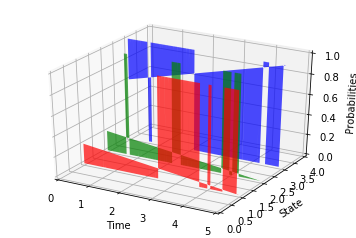

In [73]:
"""
=============================================
Probabilities as polygons to fill under 3D line graph
=============================================
"""

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import numpy as np


fig = plt.figure()
ax = fig.gca(projection='3d')


def cc(arg):
    return mcolors.to_rgba(arg, alpha=0.6)

xs = t
verts = []
zs = [1.0, 2.0, 3.0]
for i in range(len(zs)):
    print(i)
    ys = X[i,:].reshape(len(t),1)
    print(ys.shape)
    verts.append(list(zip(xs, ys)))

poly = PolyCollection(verts, facecolors=[cc('r'), cc('g'), cc('b')])
poly.set_alpha(0.7)
ax.add_collection3d(poly, zs=zs, zdir='y')

ax.set_xlabel('Time')
ax.set_xlim3d(0, FinalTime)
ax.set_ylabel('State')
ax.set_ylim3d(0, 4)
ax.set_zlabel('Probabilities')
ax.set_zlim3d(0, 1)

plt.show()

